<h1><center>ML1030 CAPSTONE PROJECT</center></h1>
<h2><center>Apply NLP Techniques to reviews of shared housing to flag any concerning comments.</center></h2>

<h3><center>Abstract</center></h3>

Founded in 2008, Airbnb now operates in nearly 200 countries and has facilitated more than 260 million home and room rentals. 
	British lawmakers last year investigated the rise of “pop-up brothels” on rental websites such as Airbnb following reports of temporary brothels springing up across Britain. Sex traffickers in the United States are reported to have used the same tactic.

<h3><center>Problem Statement</center></h3>

Toronto Police is looking to gain insight into any emerging trends regarding suspicious activity in home-sharing listings related to fraud, human sex trafficking, or any associated illegal activity in Toronto.
The data-set proposed to be used is public airbnb data found at http://insideairbnb.com/get-the-data.html as well as data available on the Toronto Police Open Data Portal: http://data.torontopolice.on.ca/.

<h3><center>Hypothesis</center></h3>

After conducting an initial interview with Toronto Police we have concluded that for the purpose of ML1030 course, the project will be mostly a text analytics project. We are going to try and spot outliers/suspicious activity by applying Natural Language Processing techniques on the airbnb reviews. Beside this, we are going to try to spot unusual behavior related to airbnb rental activity.

__Import required libraries__

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import matplotlib.pyplot as plt
import re
import nltk
#nltk.download('stopwords')
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
from nltk.util import ngrams
import re
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 


We decided to use 1 year worth of airbnb rental data downloaded from __insideairbnb__. The data is split on a month by month basis. We will have to load each month individually, then we will have to merge all dataframes we obtain after the loading process.

In [2]:
#list of each directory containing data
data_dirs = ['apr2018', 'may2018', 'jul2018', 'aug2018', 'sep2018', 'oct2018', 'nov2018', 'dec2018', 'jan2019', 'feb2019', 'mar2019']
#declare a dictionary of data frames that will hold each month's data
data_frames = {}

Load each month individually and from this create a single dataframe that contains everything. __Attention__ we observed that the data collected in 2019 has more attributes than the data collected in 2018. We are going to drop features from year 2019 that don't exit for the year 2018.

In [3]:
for grp in data_dirs:
    file_name = '../data/' + grp + '/listings.csv.gz'
    data_frames[grp] = pd.read_csv(file_name, low_memory=False, compression='gzip')
    
cols_2108 = list(data_frames['apr2018'].columns)
cols_2019 = list(data_frames['feb2019'].columns)

diff_list = list(set(cols_2019) - set(cols_2108))

#print the additional attributes that are present in 2019 but not present in 2018
print(diff_list)

['calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'maximum_maximum_nights', 'calculated_host_listings_count_entire_homes', 'minimum_minimum_nights', 'maximum_nights_avg_ntm', 'number_of_reviews_ltm', 'minimum_nights_avg_ntm', 'minimum_maximum_nights', 'maximum_minimum_nights']


The list above describes features that exist in 2019 and don't exist in 2018 data. We merge the individual dataframes below.

In [4]:
dataframes_list = []
for frame in data_frames:
    
    dataframes_list.append(data_frames[frame])
    
master_df = pd.concat(dataframes_list, axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True, sort=False)

data_frames.clear()
dataframes_list.clear()

#master_df.drop(labels=diff_list, axis=1)

print(master_df.columns.values)
print(len(master_df.columns.values))

['id' 'listing_url' 'scrape_id' 'last_scraped' 'name' 'summary' 'space'
 'description' 'experiences_offered' 'neighborhood_overview' 'notes'
 'transit' 'access' 'interaction' 'house_rules' 'thumbnail_url'
 'medium_url' 'picture_url' 'xl_picture_url' 'host_id' 'host_url'
 'host_name' 'host_since' 'host_location' 'host_about'
 'host_response_time' 'host_response_rate' 'host_acceptance_rate'
 'host_is_superhost' 'host_thumbnail_url' 'host_picture_url'
 'host_neighbourhood' 'host_listings_count' 'host_total_listings_count'
 'host_verifications' 'host_has_profile_pic' 'host_identity_verified'
 'street' 'neighbourhood' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'zipcode' 'market'
 'smart_location' 'country_code' 'country' 'latitude' 'longitude'
 'is_location_exact' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities' 'square_feet'
 'price' 'weekly_price' 'monthly_price' 'security_deposit' 'cleaning_fee'
 'guests_include

As we can notice above we have a total of 106 attributes. Some of these will be completely useless for the purpose of our project. We decided to keep only features that we are going to focus on and to drop features that are most likely not going to help us in this project.

In [5]:
diff_list.append('listing_url')
diff_list.append('scrape_id')
diff_list.append('last_scraped')
diff_list.append('space')
diff_list.append('experiences_offered')
diff_list.append('neighborhood_overview')
diff_list.append('notes')
diff_list.append('transit')
diff_list.append('access')
diff_list.append('interaction')
diff_list.append('house_rules')
diff_list.append('thumbnail_url')
diff_list.append('medium_url')
diff_list.append('picture_url')
diff_list.append('xl_picture_url')
diff_list.append('host_url')
diff_list.append('host_about')
diff_list.append('host_response_time')
diff_list.append('host_response_rate')
diff_list.append('host_acceptance_rate')
diff_list.append('host_thumbnail_url')
diff_list.append('host_picture_url')
diff_list.append('host_neighbourhood')
diff_list.append('host_verifications')
diff_list.append('host_has_profile_pic')
diff_list.append('market')
diff_list.append('smart_location')
diff_list.append('country_code')
diff_list.append('country')
diff_list.append('square_feet')
diff_list.append('weekly_price')
diff_list.append('monthly_price')
diff_list.append('security_deposit')
diff_list.append('cleaning_fee')
diff_list.append('minimum_nights')
diff_list.append('maximum_nights')
diff_list.append('calendar_updated')
diff_list.append('has_availability')
diff_list.append('availability_30')
diff_list.append('availability_60')
diff_list.append('availability_90')
diff_list.append('calendar_last_scraped')
diff_list.append('number_of_reviews')
diff_list.append('first_review')
diff_list.append('last_review')
diff_list.append('review_scores_rating')
diff_list.append('review_scores_accuracy')
diff_list.append( 'review_scores_cleanliness')
diff_list.append('review_scores_checkin')
diff_list.append('review_scores_communication')
diff_list.append('review_scores_location')
diff_list.append('review_scores_value')
diff_list.append('requires_license')
diff_list.append('license')
diff_list.append('jurisdiction_names')
diff_list.append('instant_bookable')
diff_list.append('is_business_travel_ready')
diff_list.append('cancellation_policy')
diff_list.append('require_guest_profile_picture')
diff_list.append('require_guest_phone_verification')
diff_list.append('calculated_host_listings_count') 
diff_list.append('reviews_per_month')
diff_list.append('neighbourhood_group_cleansed')
diff_list.append('zipcode')
diff_list.append('city')
diff_list.append('state')

master_df.drop(diff_list, axis=1, inplace=True)

print(master_df.columns.values)


['id' 'name' 'summary' 'description' 'host_id' 'host_name' 'host_since'
 'host_location' 'host_is_superhost' 'host_listings_count'
 'host_total_listings_count' 'host_identity_verified' 'street'
 'neighbourhood' 'neighbourhood_cleansed' 'latitude' 'longitude'
 'is_location_exact' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities' 'price'
 'guests_included' 'extra_people' 'availability_365']


This is a lot more manageable. First attribute we are going to focus on is price. Before we can do this we should fill in N/A's and format the price field so that the machine can understand it. Let's check the head of the dataframe.

In [6]:
print(master_df.head().T)

                                                                           0  \
id                                                                  24084526   
name                       Large sunny room with queen sized bed &near su...   
summary                    Private room: luxury queen sized bed.  Located...   
description                Private room: luxury queen sized bed.  Located...   
host_id                                                            157408457   
host_name                                                      Lisa & Benson   
host_since                                                        2017-11-04   
host_location                                                             CA   
host_is_superhost                                                          f   
host_listings_count                                                        7   
host_total_listings_count                                                  7   
host_identity_verified                  

We notice the __$__ symbol being in the price field. We have to remove it and convert this column from a string to a float data type.

In [7]:
master_df['price']=master_df['price'].str.replace('[$,]','',regex=True).astype(float)
master_df['extra_people']=master_df['extra_people'].str.replace('[$,]','',regex=True).astype(float)

Let's check the percentage of NA's for each field

In [8]:
print((len(master_df)-master_df.count())/len(master_df)*100)

id                           0.000000
name                         0.003529
summary                      2.870263
description                  1.241059
host_id                      0.000000
host_name                    0.083678
host_since                   0.083678
host_location                0.136607
host_is_superhost            0.083678
host_listings_count          0.083678
host_total_listings_count    0.083678
host_identity_verified       0.083678
street                       0.000000
neighbourhood                3.921282
neighbourhood_cleansed       0.000000
latitude                     0.000000
longitude                    0.000000
is_location_exact            0.000000
property_type                0.000000
room_type                    0.000000
accommodates                 0.000000
bathrooms                    0.079646
bedrooms                     0.039319
beds                         0.107874
bed_type                     0.000000
amenities                    0.000000
price       

It's not too bad. The data seems realtively clean. We will have to fill in the NA's and we will also have to convert attributes that are marked as <b>t</b> or <b>f</b> into categorical variables.

In [9]:
master_df['name']=master_df['name'].fillna(' ')
master_df['summary']=master_df['summary'].fillna(' ')
master_df['description']=master_df['description'].fillna(' ')
master_df['host_name']=master_df['host_name'].fillna(' ')
master_df['host_since']=master_df['host_since'].fillna('0')
master_df['host_location']=master_df['host_location'].fillna(' ')
# if superhost is missing (6 records) I assume that they are not + change to boolean 0,1
master_df['host_is_superhost']=master_df['host_is_superhost'].fillna('f').map({'f':0,'t':1})
master_df['host_listings_count']=master_df['host_listings_count'].fillna(1)
master_df['host_total_listings_count']=master_df['host_total_listings_count'].fillna(1)
master_df['host_identity_verified']=master_df['host_identity_verified'].fillna('f').map({'f':0,'t':1})
master_df['neighbourhood']=master_df['neighbourhood'].fillna(' ')
master_df['bathrooms']=master_df['bathrooms'].fillna(0)
master_df['bedrooms']=master_df['bedrooms'].fillna(0)
master_df['beds']=master_df['beds'].fillna(1)
master_df['is_location_exact']=master_df['is_location_exact'].fillna('f').map({'f':0,'t':1})

Let's check the price variation based on neighborhood, property type, bed type, amenities. We should also plot a heatmap of prices, bathrooms, bedrooms in the hope that we are going to be able to detect some anomalies.

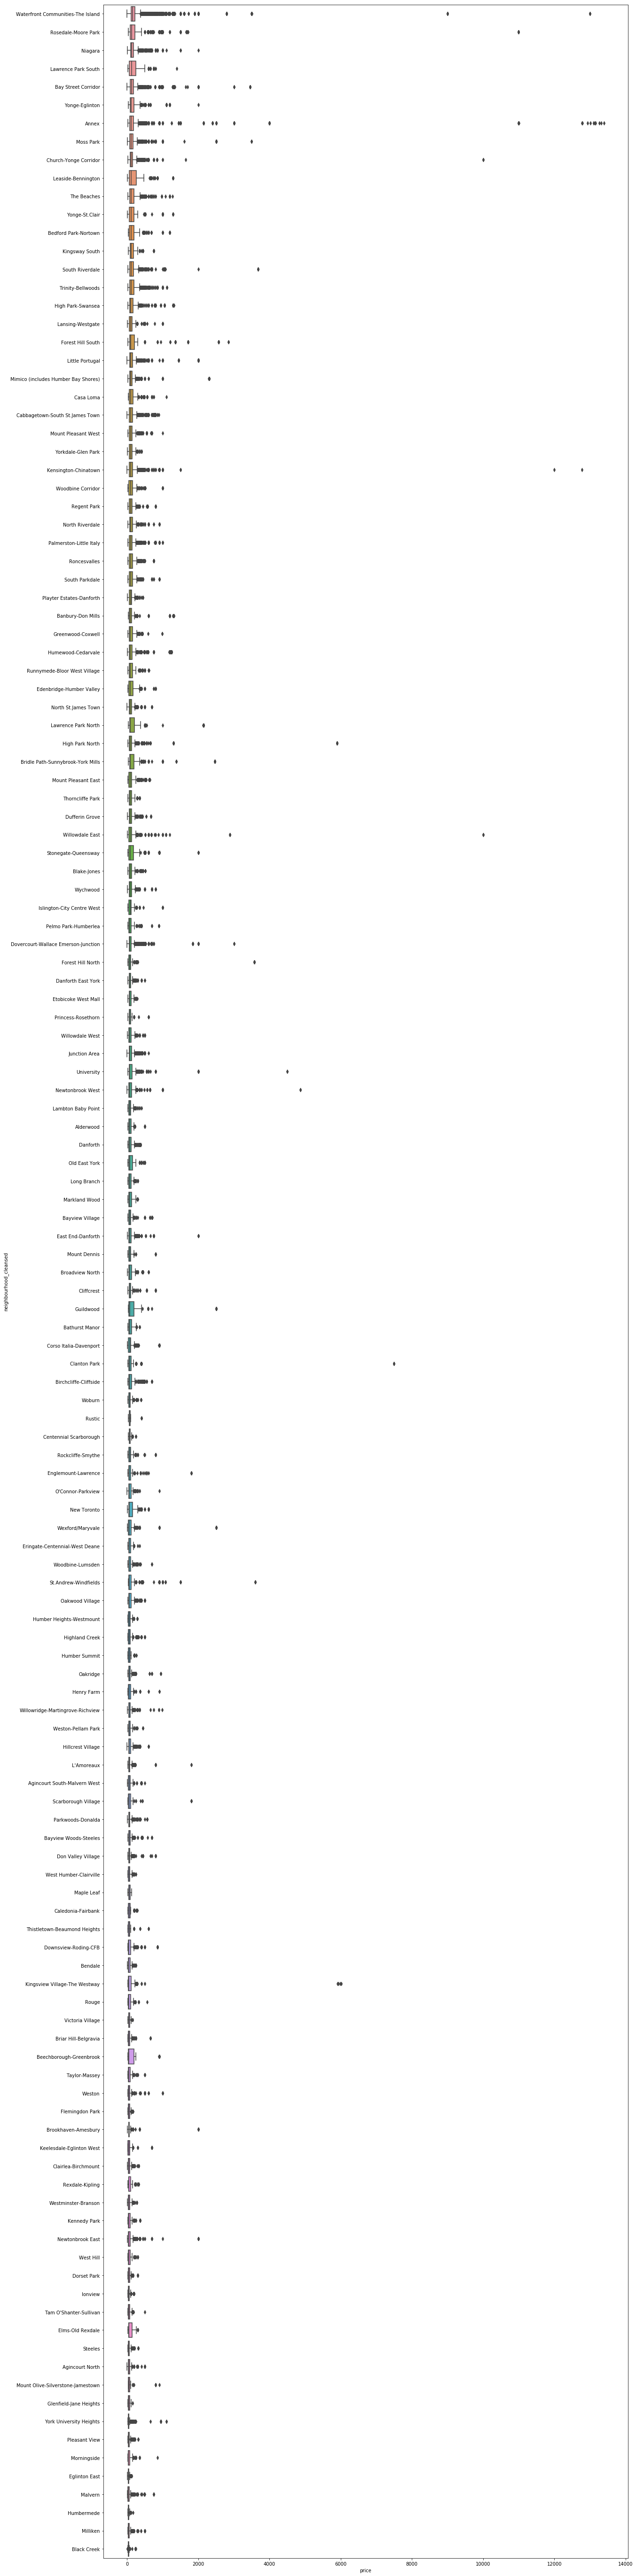

In [12]:
import matplotlib.ticker as ticker
sort_order = master_df.groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index

plt.figure(figsize=(20,100))
#plt.rcParams['figure.dpi'] = 200
#sns.set_context("poster")
sns.boxplot(x='price', y='neighbourhood_cleansed', data=master_df, order=sort_order)

#ax = plt.gca()
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

#ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
                             
plt.show()

It looks like The Annex and Kensigton Market neighbourhoods have most of our price outliers. It this a concidence? I'm not sure but we will keep this in mind and hopefully we are going to be able to use this information in subsequent analysis.

Now let's try to see if there is any substantial difference between regular hosts and superhosts.

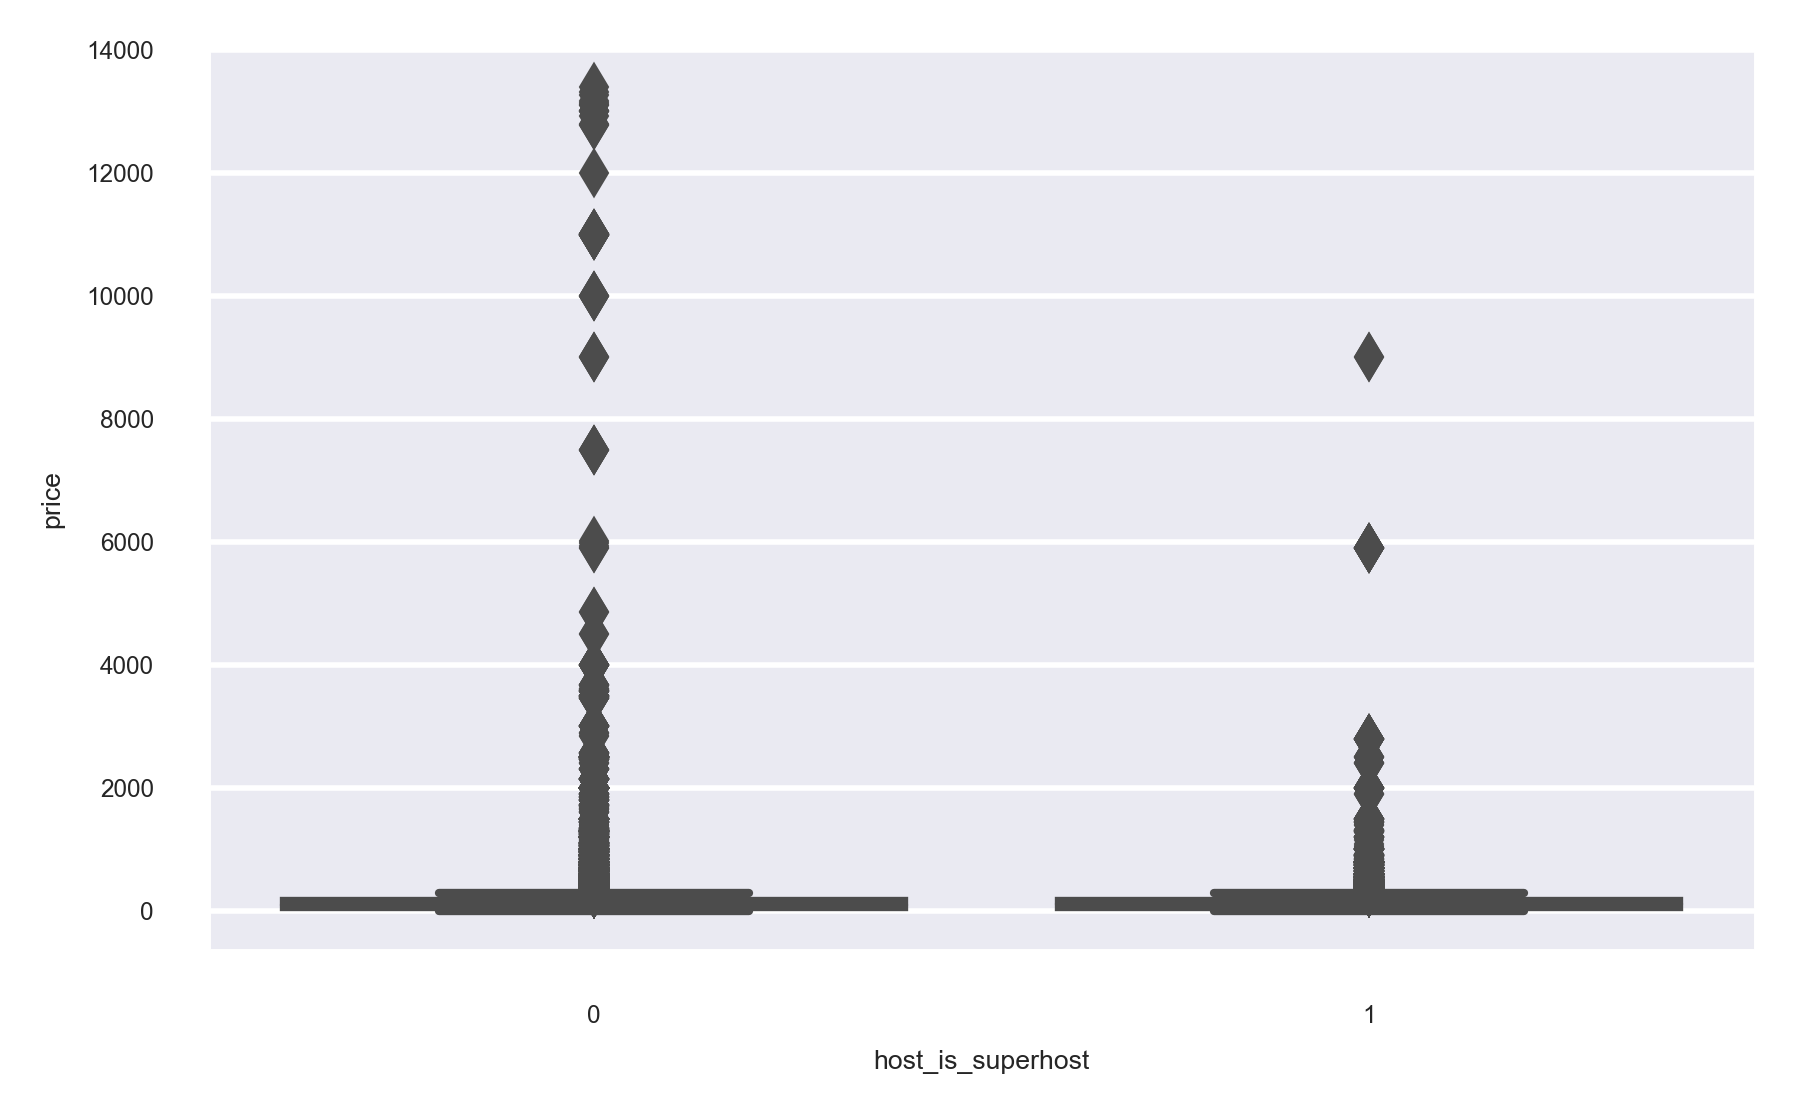

In [13]:
#plt.figure(figsize=(7.5, 4))
plt.rcParams['figure.dpi'] = 400
plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 5})
sns.set(font_scale=0.4)
sns.boxplot(y='price', x='host_is_superhost', data=master_df)

Obviously the superhost category seems to generate a lot fewer outliers. According to airbnb the superhost has to meet additional criteria to be able to qualify as superhost.

We will plot the prices vs. property type. Let's see how many outliers have for each property type.

In [17]:
sort_order = master_df.groupby('property_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
plt.figure(figsize=(20,100))
sns.set_context("paper", font_scale=2.0)
sns.boxplot(x='price', y='property_type', data=master_df, order=sort_order)
#ax = plt.gca()
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

The plot above gives us another important piece of information. It looks like condominiums have a lot more outliers than other property types. We should keep this in mind as well.

We should also check price outliers in regards with room type and bed type

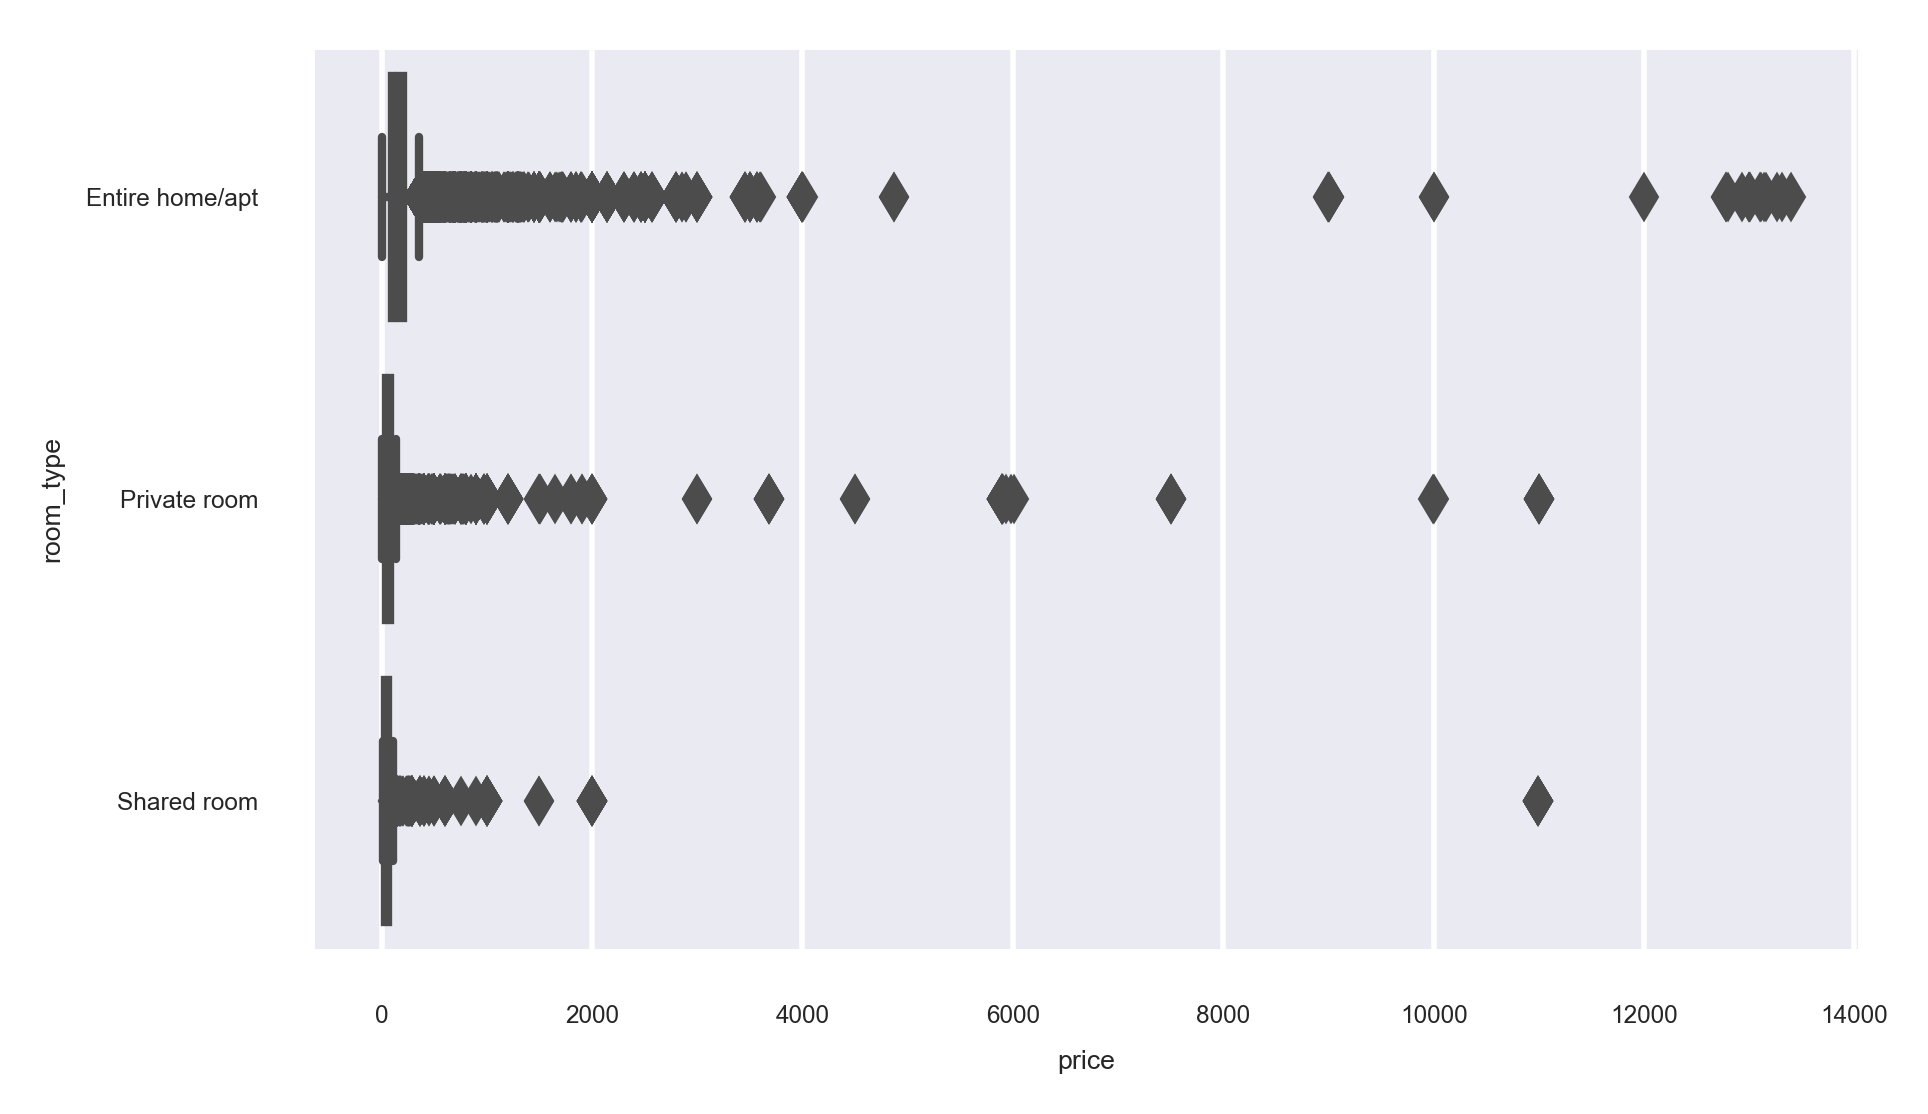

In [18]:
sort_order = master_df.groupby('room_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index

plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 5})
sns.set(font_scale=0.4)

sns.boxplot(x='price', y='room_type', data=master_df, order=sort_order)

Interesting. We expected outliers for the "Entire home/apt" category but not for "Private room"/"Shared room". Another important information we should note.

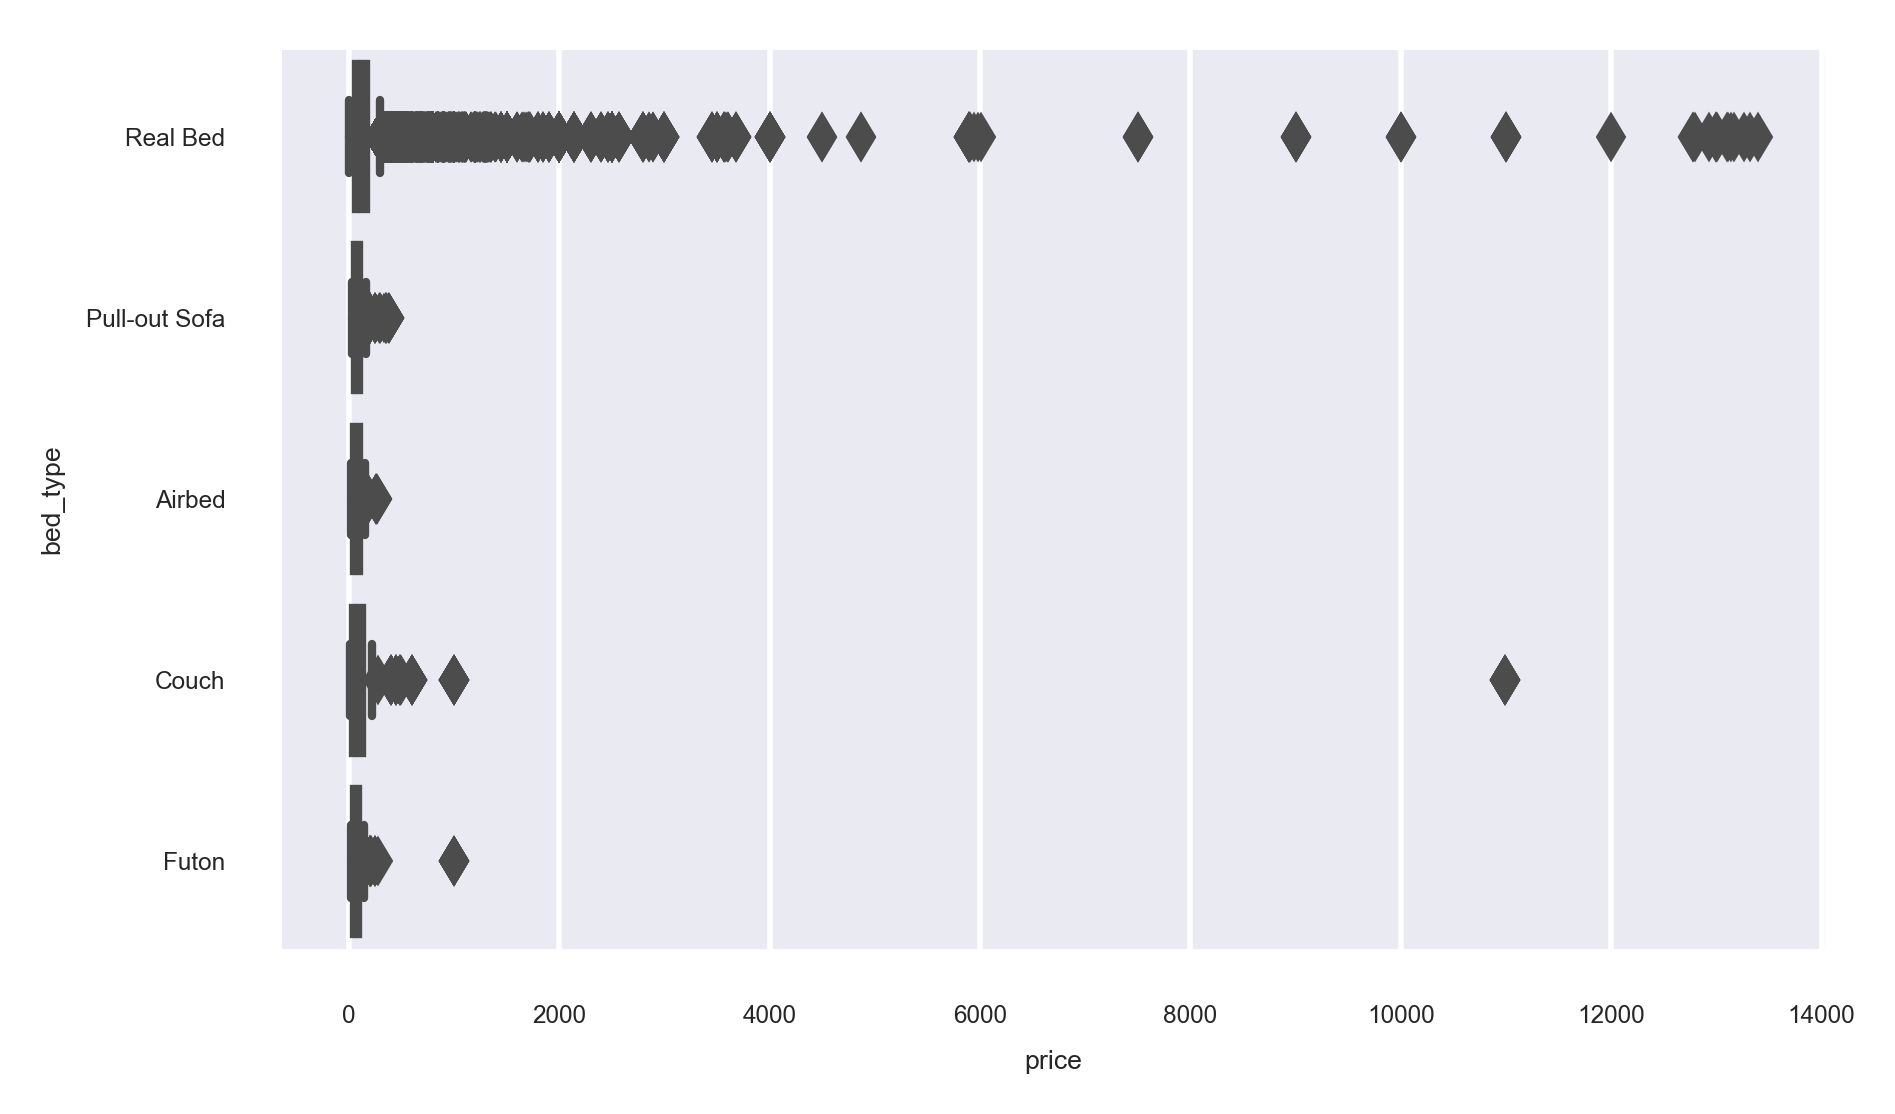

In [19]:
sort_order = master_df.groupby('bed_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 5})
sns.set(font_scale=0.4)
sns.boxplot(x='price', y='bed_type', data=master_df, order=sort_order)

Here we have one couch listing that seems suspicious. 

The heatmap below represents the number of listings plotted vs number of bathrooms and number of bedrooms.

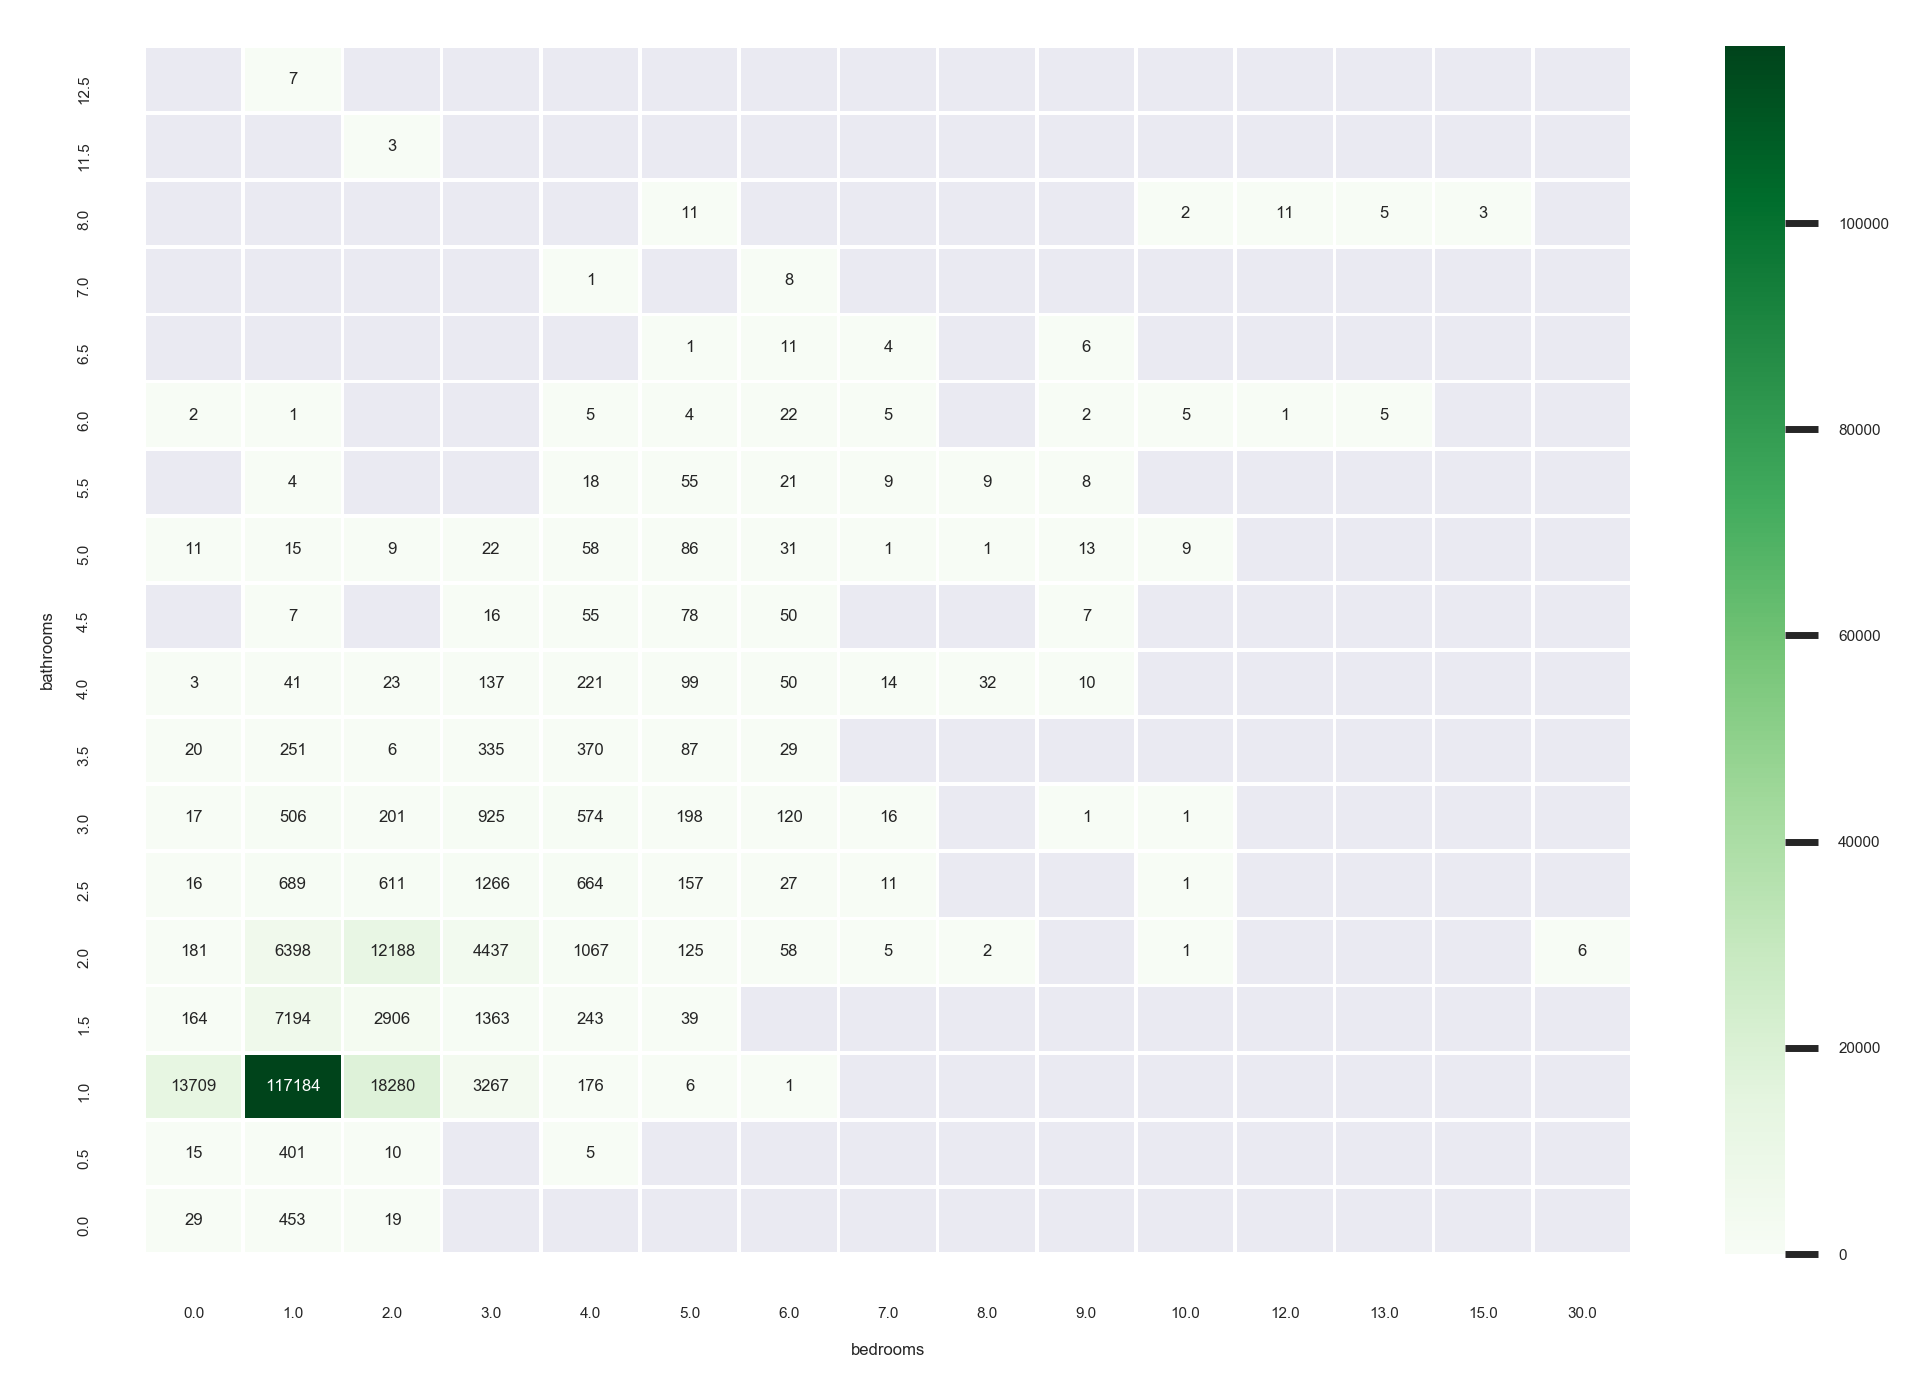

In [20]:
plt.rcParams.update({'font.size': 5})
sns.set(font_scale=0.25)
sns.heatmap(master_df.groupby(['bathrooms', 'bedrooms'])\
                .count()['price']\
                .reset_index()\
                .pivot('bathrooms', 'bedrooms', 'price')\
                .sort_index(ascending=False),
            cmap="Greens", fmt='.0f', annot=True, linewidths=0.5)

Interesting. I'm not sure if is a mistake or is something more but we seem to have a few listings that have only one bedroom and 12 bathrooms. Another piece of information that has to be used in later analysis.

Here is a similar plot but this time is the price mean vs number of bathrooms and number of bedrooms.

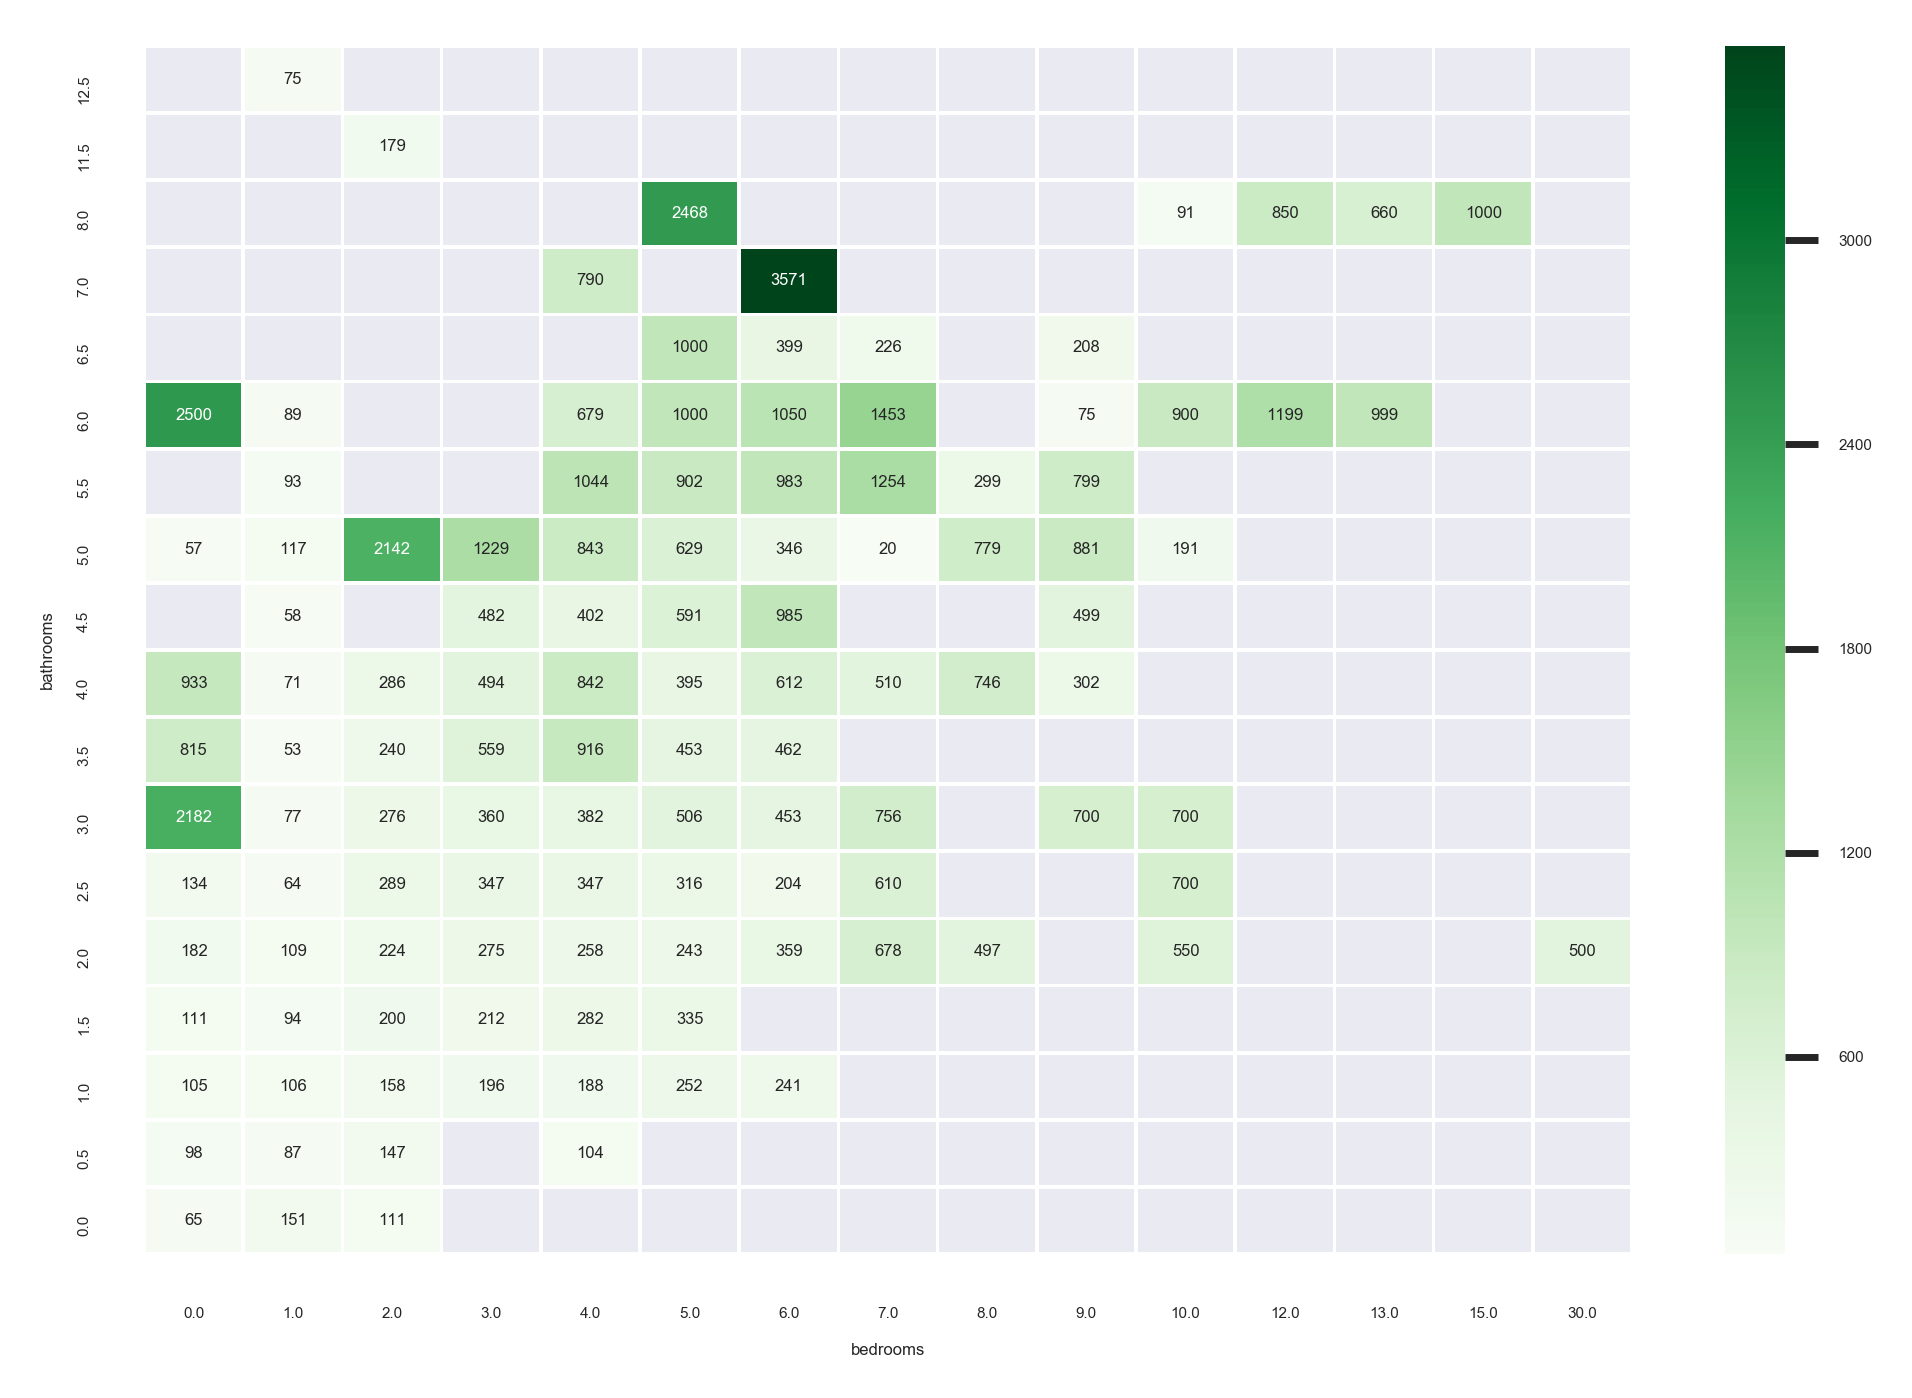

In [21]:
sns.heatmap(master_df.groupby(['bathrooms', 'bedrooms'])\
                .mean()['price']\
                .reset_index()\
                .pivot('bathrooms', 'bedrooms', 'price')\
                .sort_index(ascending=False),
            cmap="Greens", fmt='.0f', annot=True, linewidths=0.5)

The one bedroom/12 bathrooms category has a mean of only CAD 75/night.

Below we have another plot of price vs. number of beds offered

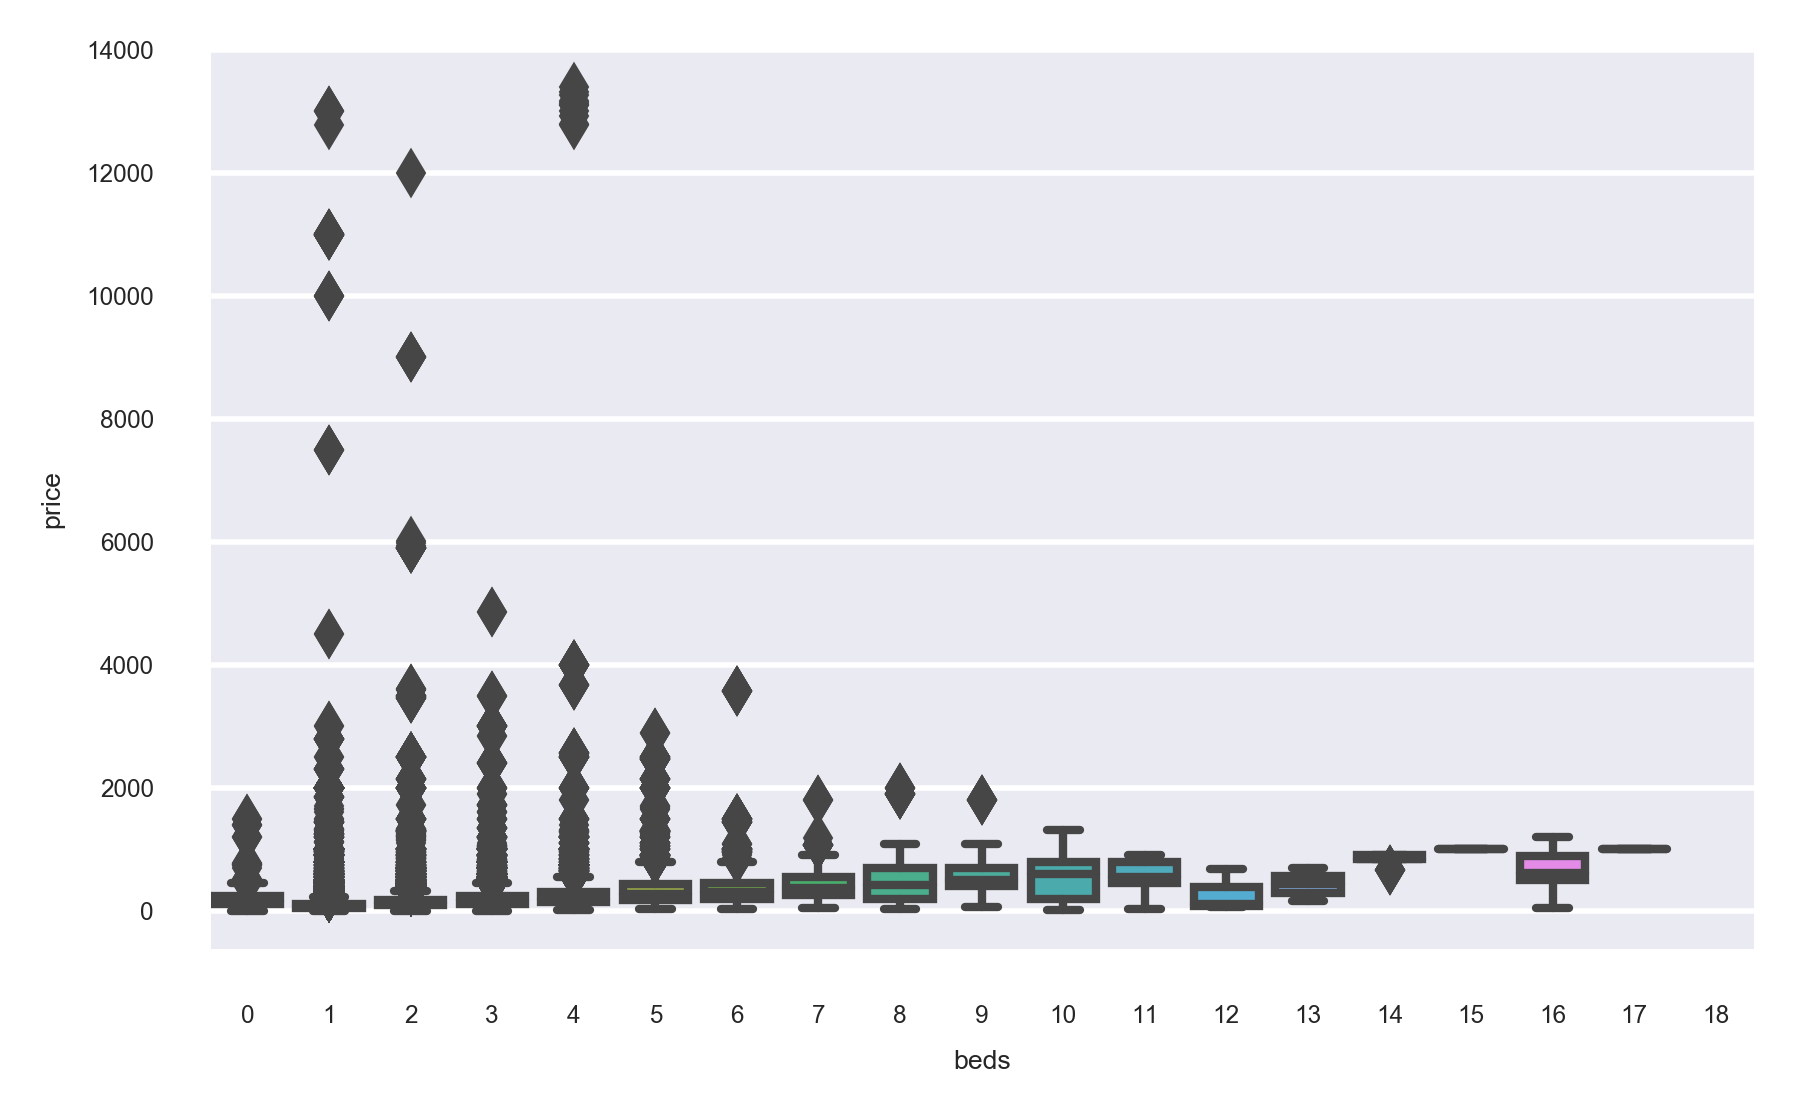

In [22]:
plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 5})
sns.set(font_scale=0.4)
sns.boxplot(y='price', x='beds', data=master_df, order=range(0,19))

We observe potential anomalies in the plot above. Another piece of information we can use later.

In [23]:
import folium
#master_df.reset_index(inplace=True)

myLat = 43.6823098050454
myLon = -79.3283423644293

city_map = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=15)

for i in range(0,len(master_df)):
    if master_df.iloc[i]['price'] > 3000:
#        print(master_df.iloc[i]['price'])
        folium.Circle(
          location=[master_df.iloc[i]['latitude'], master_df.iloc[i]['longitude']],
          radius=master_df.iloc[i]['price']/400,
          popup=str(master_df.iloc[i]['price']) + ' ' + str(master_df.iloc[i]['host_id']) + ' ' + master_df.iloc[i]['host_name'] + ' ' + master_df.iloc[i]['property_type'],
          color='crimson',
          fill=True,
          fill_color='crimson'
           ).add_to(city_map)
    


city_map

A brief analysis of the above map reveals that very high prices are being charged mostly by condominiums. Very interesting, do we see some kind of money laundering scheme going on in some cases? Let's try to plot on a map any property that would be available more than 250 days each year. This might reveal either professional AirBnB hosts or, maybe, something else?

<h3>Availability of Properties</h3>

In [24]:
import folium
myLat = 43.6823098050454
myLon = -79.3283423644293

days_map1 = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=15)
#count = 0
for i in range(0,len(master_df)):
    if master_df.iloc[i]['availability_365'] > 300 and master_df.iloc[i]['price'] > 1000:
#        count += 1

#        print(master_df.iloc[i]['price'])
        folium.Circle(
          location=[master_df.iloc[i]['latitude'], master_df.iloc[i]['longitude']],
          radius=master_df.iloc[i]['price']/400,
          popup=str(master_df.iloc[i]['price']) + ' ' + str(master_df.iloc[i]['host_id']) + ' ' + master_df.iloc[i]['host_name'] + ' ' + master_df.iloc[i]['property_type'] + ' ' + str(master_df.iloc[i]['availability_365']),
          color='crimson',
          fill=True,
          fill_color='crimson'
           ).add_to(days_map1)
    

#print(count)
days_map1

The plot above seems to point again to the fact that condominiums might be used for scams or something else that would be illegal. We are going to try and run an SVM on the data with the hope that we can detect outliers(https://www.kaggle.com/lrthtn/potential-outliers-detection).

<h3>SVM Classifier</h3>

In [88]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope


def displayResults(inliers, outliers, classifier, outputTitle):
    
    plt.figure()        
    
    # Defining grid
    gridX, gridY = np.meshgrid(np.linspace(-0.5, 1.5, 1000), np.linspace(-0.5, 1.5, 1000))
    
    # Computing decision for each point of the grid
    gridDecisions = classifier.decision_function(np.c_[gridX.ravel(), gridY.ravel()])
    
    # Plotting decision boundary (each point of the grid whose decision value is 0)
    gridDecisions = gridDecisions.reshape(gridX.shape)
    plotBoundary = plt.contour(gridX, gridY, gridDecisions, levels=[0], linewidths=2, colors='blue')
    plt.clabel(plotBoundary, inline=1, fontsize=12)

    # Plotting inliers and outliers
    plt.scatter(inliers.loc[:, 'accommodates'], inliers.loc[:, 'price'], label="Inliers", color='green', alpha=0.2)
    plt.scatter(outliers.loc[:, 'accommodates'], outliers.loc[:, 'price'], label="Outliers", color='red', alpha=1.0)
    
    plt.xlabel("Accomodates (normalized)")
    plt.ylabel("Price (normalized)")
    plt.title(outputTitle)
    plt.legend()    
    plt.show()
    
def getClassifierRobustCovariance(data):

    #------------------------------------------------------------------------------
    # Checking prerequisites
    #------------------------------------------------------------------------------

    numberOfSamples = data.shape[0]
    numberOfFeatures = data.shape[1]
    
    if (numberOfSamples > numberOfFeatures ** 2):
        
        #------------------------------------------------------------------------------
        # Preparing and fitting model
        #------------------------------------------------------------------------------
        
        # Initializing classifier
        classifier = EllipticEnvelope(contamination=0.001)
        
        # Fitting classifier
        classifier.fit(data)
        
        return classifier
       
    return None


def getClassifierOneClassSVM(data):

    #------------------------------------------------------------------------------
    # Preparing and fitting model
    #------------------------------------------------------------------------------    
    
    # Initializing classifier
    classifier = svm.OneClassSVM(nu=0.003, gamma=2.0)
    
    # Fitting classifier
    classifier.fit(data)
    
    return classifier

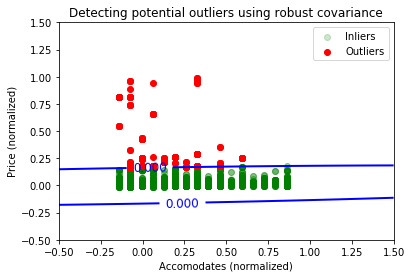

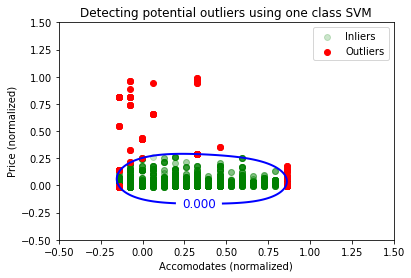

In [95]:


listings_features = master_df.loc[:, ['accommodates', 'price']]

# Fixing price column (removing unit, removing commas, converting to float)
#listings_features.loc[:, 'price'] = listings_features.loc[:, 'price'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.float)

# Normalizing features
listings_features = (listings_features - listings_features.mean()) / (listings_features.max() - listings_features.min())    

#------------------------------------------------------------------------------
# Detecting outliers with robust covariance
#------------------------------------------------------------------------------

# Getting classifier
classifierRobustCovariance = getClassifierRobustCovariance(listings_features)

# Classifying inliers/outliers
decisionsRobustCovariance = classifierRobustCovariance.decision_function(listings_features)

# Displaying results
displayResults(inliers=listings_features[decisionsRobustCovariance >= 0],
               outliers=listings_features[decisionsRobustCovariance < 0],
               classifier=classifierRobustCovariance,
               outputTitle = "Detecting potential outliers using robust covariance")

#------------------------------------------------------------------------------
# Detecting outliers with one class SVM
#------------------------------------------------------------------------------
# Getting classifier
classifierOneClassSVM = getClassifierOneClassSVM(listings_features)

# Classifying inliers/outliers
decisionsOneClassSVM = classifierOneClassSVM.decision_function(listings_features)

# Displaying results
displayResults(inliers=listings_features[decisionsOneClassSVM >= 0],
               outliers=listings_features[decisionsOneClassSVM < 0],
               classifier=classifierOneClassSVM,
               outputTitle = "Detecting potential outliers using one class SVM")


Interesting. We should probably try to understand the outliers in this data. What makes some listings much more different that the rest.

Now is time to cleanup the textual information and use this information to feed it trough __Google's Universal Sentence Encoder__ to generate features. These features will be used in a later analysis to try and spot unusual behaviour.

In [27]:
def ProcessTextData(sentence):
    text_data = sentence
    text_data = text_data.lower()
    #removes unicode strings
    text_data = re.sub(r'(\\u[0-9A-Fa-f])', r'', text_data)
    text_data = re.sub(r'[^\x00-\x7f]', r'', text_data)
    #convert any url to URL
    text_data = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text_data)
    #convert any @user to AT_USER
    text_data = re.sub('@[^\s]+', 'AT_USER', text_data)
    #remove additional white spaces
    text_data = re.sub('[\s]+', ' ', text_data)
    text_data = re.sub('[\n]+', ' ', text_data)
    #remove not alphanumeric symbols white spaces
    text_data = re.sub(r'[^\w]+', ' ', text_data)
    #remove numbers
    text_data = ''.join([i for i in text_data if not i.isdigit()])
    
    lemmatizer = WordNetLemmatizer()
    
    word_list = nltk.word_tokenize(text_data)
    
    stop_words = set(stopwords.words('english')) 
    
    filtered_sentence = [w for w in word_list if not w in stop_words]
    
# Lemmatize list of words and join
    text_data = ' '.join([lemmatizer.lemmatize(w) for w in filtered_sentence])

#    text_data = " ".join([Word(word).lemmatize for word in text_data.split()])
    #stemmer
#    st = PorterStemmer()
#   text_data = " ".join([st.stem(word) for word in text_data.split()])
    
    sentence = text_data
    return sentence

In [28]:
master_df['name'] = master_df['name'].apply(ProcessTextData)
master_df['summary'] = master_df['summary'].apply(ProcessTextData)
master_df['description'] = master_df['description'].apply(ProcessTextData)
master_df['amenities'] = master_df['amenities'].apply(ProcessTextData)

The code below has been used to generate features vectors for listings description. We plan to group listings in individual clusters and try to find unusual clusters. The features generated based on description text will be one clustering criteria.

In [ ]:
import numpy as np 
import pandas as pd
import spacy
import re
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
from gensim.summarization import summarize,keywords
import warnings
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns

import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import tensorflow as tf
import tensorflow_hub as hub
import csv



embed = hub.Module("../module_use")
# Compute a representation for each message, showing various lengths supported.
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)
    

data_clean =  pd.read_csv('../data/data_clean.csv')

description_list = data_clean.description.fillna("aaabbb")

for i in range(len(description_list)):
    if len(description_list[i]) < 3:
        description_list[i] = 'aaabbb'

dl = description_list.tolist()

print(len(dl))

index_start = 0
index_end = 0

for ndx in range(187000, len(dl), 200):
    index_start = ndx
    index_end = ndx + 200
    
    if index_end > len(dl):
        index_end = len(dl)
        
    filename = 'desv_vec' + str(index_start) + '_' + str(index_end) + '.csv'
    
    print(filename)
    
    small_dl = dl[index_start:index_end]
    
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        message_embeddings = session.run(embed(small_dl))
        
    with open(filename, 'a') as writeFile:
        writer = csv.writer(writeFile)
    
        for msge in message_embeddings:
            writer.writerow(msge)
        
    writeFile.close()

print('Done')        

Due to high memory consumption of the Universal Feature Encoder we had to run the above code on batches of data, then the features that have been generated have been appended to our dataframe. The code below has been used to merge the description features into our dataframe.

In [ ]:
import csv
import numpy as np 
import pandas as pd
import string


index_start = 0
index_end = 0

data_array = []

root_filename = './text_vectors/desv_vec'

print('Start')
for ndx in range(0, 198200, 200):
    index_start = ndx
    index_end = ndx + 200
    filename = root_filename + str(index_start) + '_' + str(index_end) + '.csv'
    
    try:
        with open(filename) as f:
            for line in f:
                data_array.append(line)
        
    except IOError:
        print('IOError: for file ', filename)
        raise
        

index_start = 198200
index_end = 198379
filename = root_filename + str(index_start) + '_' + str(index_end) + '.csv'


try:
    with open(filename) as f:
        for line in f:
            data_array.append(line)
    
except IOError:
    print('IOError: for file ', filename)
    raise
        

print('Done') 
print(len(data_array))

data_clean =  pd.read_csv('../data/data_clean.csv')

#default_value = np.zeros(512)
#data_clean['description_features'] = ' '
#data_clean['description_features'] = False
features_list = []

#data_clean = data_clean.assign(description_features=lambda x: np.zeros(512))
counter = 0
for line in data_array:
#    features_array = []
#    features_array = line.split(',')
    line = line.replace('\n', '')
    features_list.append(line.split(','))
#    data_clean.iloc[counter, data_clean.columns.get_loc('description_features')].values = features_array
    counter += 1

del data_array
print('After loop')   

features_series = pd.Series(features_list)
del features_list
#del features_array
#print(features_series.head())
#data_clean.add(features_series, axis=1)   
concatenated_data = pd.concat([data_clean, features_series], axis=1) 
concatenated_data.to_csv('data_features_clean.csv')

print('Finished')

<h2><center>Reviews analysis</center></h2>

It's time now to look into listings reviews. Due to sheer volume of data we are going to load only one month of reviews and run our analysis on it. We will have to run this code for the entire year but this will have to be done on either GCP or Amazon.

In [30]:
import pandas as pd
from textblob import TextBlob
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [31]:
reviews = pd.read_csv("../data/reviews.csv")

In [32]:
reviews.head()

listing_id         id        date  reviewer_id reviewer_name  \
0        1419   38924112  2015-07-19     11308465       Marcela   
1        1419   44791978  2015-08-29      9580285         Marco   
2        1419   45957133  2015-09-07     38394721        Andrea   
3        1419   67295154  2016-03-28      3515044         Shaun   
4        1419  177702208  2017-08-03     13987100          Kate   

                                            comments  
0  Having the opportunity of arriving to Alexandr...  
1  We have no enough words to describe how beauty...  
2  The listing was exceptional and an even better...  
3  Alexandra's home was amazing and in such a nea...  
4  Beautiful home. Very comfortable and clean. Pe...

We notice above that the data contains listings id's, and reviewer id's beside the text of the review. We will use this information at a later time. 
We are going to use TextBlob to do some sentiment analysis and use this data later on.

In [33]:
reviews["sentiment"] = reviews["comments"].map(lambda x: TextBlob(str(x)).polarity)
reviews["subjectivity"] = reviews["comments"].map(lambda x: TextBlob(str(x)).subjectivity)
reviews.head()

listing_id         id        date  reviewer_id reviewer_name  \
0        1419   38924112  2015-07-19     11308465       Marcela   
1        1419   44791978  2015-08-29      9580285         Marco   
2        1419   45957133  2015-09-07     38394721        Andrea   
3        1419   67295154  2016-03-28      3515044         Shaun   
4        1419  177702208  2017-08-03     13987100          Kate   

                                            comments  sentiment  subjectivity  
0  Having the opportunity of arriving to Alexandr...   0.410104      0.699479  
1  We have no enough words to describe how beauty...   0.266667      0.683333  
2  The listing was exceptional and an even better...   0.576111      0.717361  
3  Alexandra's home was amazing and in such a nea...   0.295000      0.563333  
4  Beautiful home. Very comfortable and clean. Pe...   0.502963      0.740000

Due to time constraints we will NOT run the code below in this notebook. We just wanted to show how the data cleaning has been done and how we have generated the similarity matrix.

In [ ]:
reviews["comments_cleaned"] = reviews["comments"].apply(ProcessTextData)

reviews.to_csv("reviews_cleaned.csv", index=False, header=True)

__Compute Similarity Metric__

In [ ]:
from gensim.matutils import softcossim
from gensim import corpora
import gensim.downloader as api

# Download the models.
#Takes a lot of time to download
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')

from gensim.utils import simple_preprocess

#prepare a dictionary and corpus
dictionary = corpora.Dictionary([simple_preprocess(doc) for doc in documents])

#prepare the similarity matrix
similarity_matrix = fasttext_model300.similarity_matrix(dictionary, 
                                                        tfidf=None,
                                                        threshold=0.0,
                                                        exponent=2.0,
                                                        nonzero_limit=100)

#convert the sentences into bag-of-words vectors
bow = [dictionary.doc2bow(simple_preprocess(doc)) for doc in documents]

from gensim.matutils import softcossim

#compute soft cosine similarity
softcossim(bow[1], bow[2], similarity_matrix)

indexes = list(range(len(reviews)))

m = np.array(reviews["comments_cleaned"])

from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile
from gensim.similarities import Similarity

index_tmpfile = get_tmpfile("index")
query = [(1,2), (6,1), (7,2)]

#build the index
index = Similarity(index_tmpfile, common_corpus, num_features=len(common_dictionary))

#get similarities b/w the query and all the index documents
similarities = index[query] 



__Reviews Clustering__

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [39]:
import pandas as pd
df = pd.read_csv("./text_vectors/reviews_cleaned.csv")

/home/silviu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (0,2,4,5,8) have mixed types. Specify dtype option on import or set low_memory=False.



In [40]:
df.head()

listing_id           id        date  reviewer_id reviewer_name  \
0       1419   38924112.0  2015-07-19   11308465.0       Marcela   
1       1419   44791978.0  2015-08-29    9580285.0         Marco   
2       1419   45957133.0  2015-09-07   38394721.0        Andrea   
3       1419   67295154.0  2016-03-28    3515044.0         Shaun   
4       1419  177702208.0  2017-08-03   13987100.0          Kate   

                                            comments  sentiment  subjectivity  \
0  Having the opportunity of arriving to Alexandr...   0.410104      0.699479   
1  We have no enough words to describe how beauty...   0.266667      0.683333   
2  The listing was exceptional and an even better...   0.576111      0.717361   
3  Alexandra's home was amazing and in such a nea...   0.295000      0.563333   
4  Beautiful home. Very comfortable and clean. Pe...   0.502963      0.740000   

                                    comments_cleaned  
0  opportunity arriving alexandra house describes...  
1  enough word describe beautyful cozy alexandra ...  
2  listing exceptional even better experience per...  
3  alexandra home amazing neat neighbourhood ever...  
4  beautiful home comfortable clean perfect famil...

In [41]:
df["comments_cleaned"] = df["comments_cleaned"].astype(str)

In [42]:
reviews = df["comments_cleaned"]

In [43]:
len(reviews)

609669

As we can see above we have over 600000 review for a single month. The code below is the clustering implemented listings reviews.

<b>Pickle the model</b>

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(reviews)

true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

import pickle
pickle.dump(model, open("model.bin","wb"))
pickle.dump(order_centroids, open("order_centroids.bin","wb"))
pickle.dump(terms, open("terms.bin","wb"))

review_cluster = []

for i in reviews.index:    
    Y = vectorizer.transform([reviews[i]])
    prediction = model.predict(Y)   
    review_cluster.append(prediction)
    
df["clusterid"] = [x[0] for x in review_cluster]

df.to_csv("reviews_cluster.csv", index=False, header=True)


<center><h2>Group by property description features analysis</h2></center>

In this exercise we are going to group all listings based on features extracted from property description. We would like to visualize mean prices accross different groups in the hope that we are going to be able to spot some outliers.

First load data that has been already cleaned.

In [2]:
import numpy as np 
import pandas as pd
import nltk
from nltk.cluster import KMeansClusterer
import matplotlib.pyplot as plt

master_df = pd.read_csv('data_features_clean.csv')

In [2]:
master_df.head().T

0  \
Unnamed: 0                                                                 0   
Unnamed: 0.1                                                               0   
id                                                                  24084526   
name                            large sunny room queen sized bed near subway   
summary                    private room luxury queen sized bed located qu...   
description                private room luxury queen sized bed located qu...   
host_id                                                            157408457   
host_name                                                      Lisa & Benson   
host_since                                                        2017-11-04   
host_location                                                             CA   
host_about                 Hi we are Lisa and Benson, \r\nWe welcome you ...   
host_is_superhost                                                          0   
host_listings_count                                                        7   
host_total_listings_count                                                  7   
host_identity_verified                                                     0   
street                                                   Toronto, ON, Canada   
neighbourhood                                        York University Heights   
neighbourhood_cleansed                               York University Heights   
latitude                                                             43.7526   
longitude                                                           -79.5077   
is_location_exact                                                          1   
property_type                                                          House   
room_type                                                       Private room   
accommodates                                                               2   
bathrooms                                                                  1   
bedrooms                                                                   1   
beds                                                                       1   
bed_type                                                            Real Bed   
amenities                  wifi air conditioning kitchen free parking pre...   
price                                                                     40   
guests_included                                                            1   
extra_people                                                              10   
availability_365                                                         171   
desc_features              ['-0.106930874', '-0.03466785', '-0.037711095'...   

                                                                           1  \
Unnamed: 0                                                                 1   
Unnamed: 0.1                                                               1   
id                                                                  23663025   
name                                      room york university subway around   
summary                    bright room york university subway store resta...   
description                bright room york university subway store resta...   
host_id                                                             43488381   
host_name                                                            Runying   
host_since                                                        2015-09-06   
host_location                                                             CA   
host_about                 I have been Professional landlord for 17 years...   
host_is_superhost                                                          0   
host_listings_count                                                       33   
host_total_listings_count                                                 33   
host_identity_verified                                                    

In [3]:
master_df = master_df.drop('Unnamed: 0', axis=1)
master_df = master_df.drop('Unnamed: 0.1', axis=1)
master_df.reset_index(inplace=True)

We know that the description features contained in our dataframe have been loaded as strings. We will have to clean up this and format it so that at the end we have an array of floating point numbers that can be used as our features vectors.

In [4]:
master_df.loc[:, 'desc_features'] = master_df.loc[:, 'desc_features'].apply(lambda x: x.replace('[','')).apply(lambda x: x.replace(']',''))
master_df.loc[:, 'desc_features'] = master_df.loc[:, 'desc_features'].apply(lambda x: x.replace('\'','')).apply(lambda x: x.replace(',',' '))
master_df.loc[:, 'desc_features'] = master_df.loc[:, 'desc_features'].apply(lambda x: x.replace('  ',' '))
master_df['desc_features'] = master_df['desc_features'].apply(lambda x : [float(i) for i in x.split(' ')])
master_df['desc_features'] = master_df['desc_features'].apply(lambda x : np.asarray(x))

In [4]:
X = master_df['desc_features']

In [6]:
NUM_CLUSTERS=20

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

In [7]:
print(len(assigned_clusters))

198379


In [9]:
import csv

csv_file = open('clusters.csv', "w")

columnTitleRow = "cluster\n"
csv_file.write(columnTitleRow)

for key in assigned_clusters:
    row = str(key) + "\n"
    csv_file.write(row)
    
csv_file.close()

Since we have the clusters let's check how many listings each cluster contains.

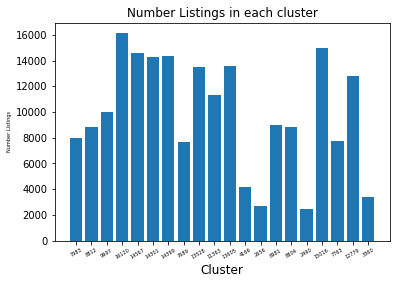

In [12]:
master_df['cluster'] = assigned_clusters
data_groups = master_df.groupby(["cluster"]).count().reset_index()[["cluster","id"]].sort_values(by=["id"],ascending=False).reset_index(drop=True)

plt.bar(data_groups['cluster'], data_groups['id'])
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number Listings', fontsize=5)
plt.xticks(data_groups['cluster'], data_groups['id'], fontsize=5, rotation=30)
plt.title('Number Listings in each cluster')
plt.show()

Interesting. We have a couple of clusters that contain a lot fewer listings than most clusters. Maybe it's time to check median price distribution across clusters.

In [15]:
price_groups = master_df.groupby(["cluster"])[["price"]].median().reset_index()

In [16]:
price_groups.head().T

0     1     2     3     4
cluster   0.0   1.0   2.0   3.0   4.0
price    54.0  69.0  85.0  81.0  80.0

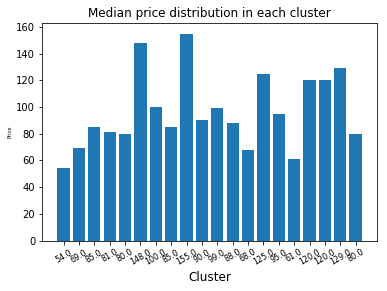

In [18]:
plt.bar(price_groups['cluster'], price_groups['price'])
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Price', fontsize=5)
plt.xticks(price_groups['cluster'], price_groups['price'], fontsize=8, rotation=30)
plt.title('Median price distribution in each cluster')
plt.show()

Now, we have the median price. Maybe is time to check the maximum price distribution.

In [19]:
max_price_groups = master_df.groupby(["cluster"])[["price"]].max().reset_index()

In [20]:
max_price_groups.head().T

0       1       2       3       4
cluster    0.0     1.0     2.0     3.0     4.0
price    990.0  5901.0  1999.0  2143.0  3000.0

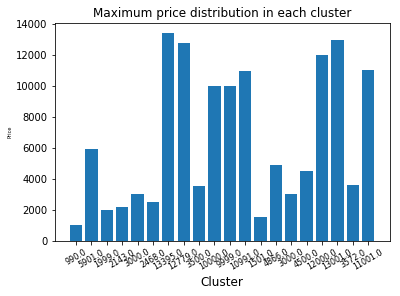

In [22]:
plt.bar(max_price_groups['cluster'], max_price_groups['price'])
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Price', fontsize=5)
plt.xticks(max_price_groups['cluster'], max_price_groups['price'], fontsize=8, rotation=30)
plt.title('Maximum price distribution in each cluster')
plt.show()

This might be interesting. Why only some groups have such a high price. We should probably look into the wording used for listing description. Some clusters seem to have outrageously high prices. Why?
Let's look into minimum price for each cluster.

In [24]:
min_price_groups = master_df.groupby(["cluster"])[["price"]].min().reset_index()

In [27]:
min_price_groups.head().T

0     1    2    3    4
cluster  0.0   1.0  2.0  3.0  4.0
price    0.0  13.0  0.0  0.0  0.0

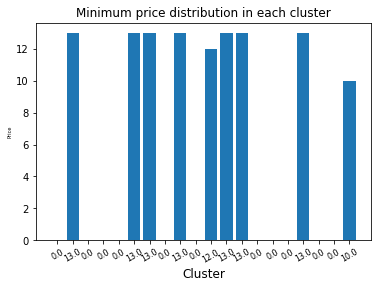

In [28]:
plt.bar(min_price_groups['cluster'], min_price_groups['price'])
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Price', fontsize=5)
plt.xticks(min_price_groups['cluster'], min_price_groups['price'], fontsize=8, rotation=30)
plt.title('Minimum price distribution in each cluster')
plt.show()

Since I used KMeans for clustering I decided to try a DBSCAN as well. I would like to check how many clusters DBSCAN will come up with and the clusters distribution.

In [31]:
X.head()

0    [-0.106930874, -0.03466785, -0.037711095, -0.0...
1    [-0.05453392, -0.015211012, 0.029151766, -0.00...
2    [-0.075505786, -0.019704577, 0.016768884, -0.0...
3    [-0.09673086, -0.04661698, 0.0066192867, -0.02...
4    [-0.07178452, -0.03199304, 0.02412561, 0.00041...
Name: desc_features, dtype: object

Try to find hosts that have multiple listings accross the timeline. Let's see if we can infer something from this.

In [6]:
hosts = master_df.groupby(["host_id"]).count().reset_index()[["host_id","id"]].sort_values(by=["id"],ascending=False).reset_index(drop=True)
hosts_multiple_listings = hosts[hosts["id"]>1]

Let's check how many hosts have multiple listings, then we will also check how many unnique hosts we have in total.

In [7]:
print(len(hosts_multiple_listings))

16819


In [9]:
unique_hosts = master_df.host_id.unique()
print(len(unique_hosts))

18850


It looks like the difference between the number of host that have multiple listinmgs and the total number of hosts is not that big. Let's see how the data looks for hosts that have listed multiple properties.

In [10]:
hosts_multiple_listings.head().T

0         1       2         3        4
host_id  1919294  12742095  534666  43488381  2479385
id           794       745     489       481      407

In [26]:
hosts_many_listings = hosts_multiple_listings.loc[hosts_multiple_listings['id'] > 100]
hosts_many_listings.reset_index(inplace=True)
hosts_many_listings.head()

index   host_id   id
0      0   1919294  794
1      1  12742095  745
2      2    534666  489
3      3  43488381  481
4      4   2479385  407

In [27]:
print(len(hosts_many_listings))

91


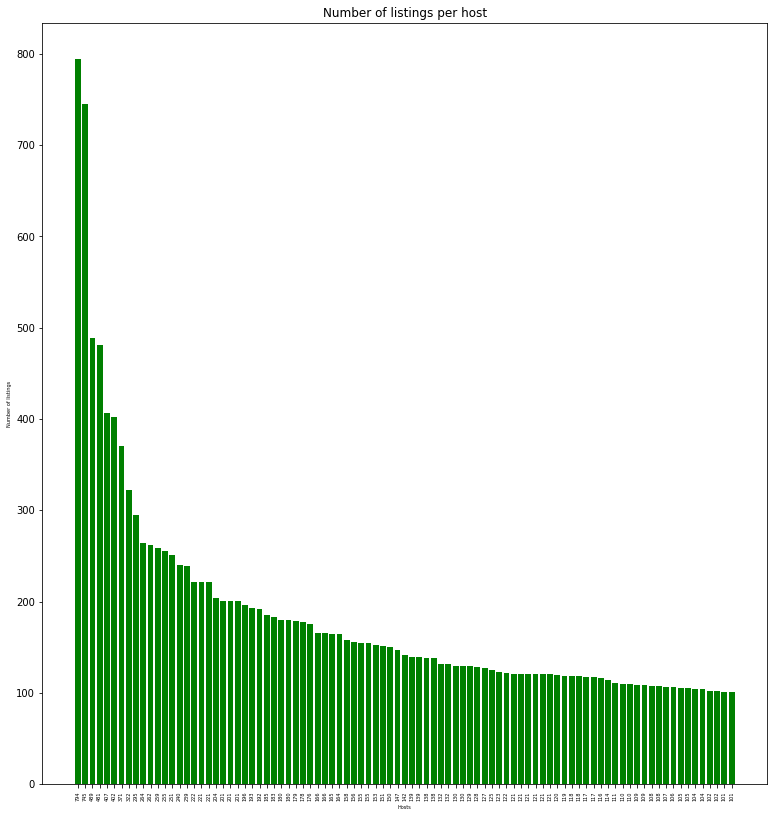

In [33]:
plt.figure(figsize=(13,14))
plt.bar(hosts_many_listings['index'], hosts_many_listings['id'], color='green')
plt.xlabel('Hosts', fontsize=5)
plt.ylabel('Number of listings', fontsize=5)
plt.xticks(hosts_many_listings['index'], hosts_many_listings['id'], fontsize=5, rotation=90)
plt.title('Number of listings per host')
#plt.xticks([])
plt.show()

Very interesting. Some hosts seem to be doing this on a very large scale. Maybe we should plot on a map where thse properties are located.

In [68]:
hosts_many_listings = hosts_multiple_listings.loc[hosts_multiple_listings['id'] > 300]
hosts_many_listings.reset_index(inplace=True)
hosts_many_listings.head(n=8)

index   host_id   id
0      0   1919294  794
1      1  12742095  745
2      2    534666  489
3      3  43488381  481
4      4   2479385  407
5      5  49288354  402
6      6  26743967  371
7      7  33238402  322

In [35]:
print(len(hosts_many_listings))

8


It looks like we have only 8 hosts that own over 300 listings. Maybe we should check what is the total number of listings

In [69]:
total_listings = hosts_many_listings['id'].sum()
print(total_listings)

4011


These 8 hosts have a total of 4011 listings. Maybe we should try to plot them on a map just to see if we can notice something.

In [70]:
listings_dict = {}

for key in hosts_many_listings.host_id:

    listings_dict[key] = master_df.loc[master_df['host_id'] == key]

How many of these listings are real and how many are duplicates? Let's try to find out.

In [73]:
lat_long_dict = {}
for key, value in listings_dict.items():
    #listings_dict[key] = value.groupby(['latitude', 'longitude']).size().reset_index()
    lat_long_dict[key] = value.groupby(['latitude', 'longitude']).size().to_frame(name='count').reset_index()
#    listings_dict[key] = pd.DataFrame({'count' : value.groupby(['latitude', 'longitude']).size()}).reset_index()
    print('Host ' + str(key) + ' listings ' + str(len(lat_long_dict[key])))

Host 1919294 listings 176
Host 12742095 listings 209
Host 534666 listings 126
Host 43488381 listings 229
Host 2479385 listings 91
Host 49288354 listings 106
Host 26743967 listings 89
Host 33238402 listings 106


Interesting, why would somebody have multiple listings for the same location. I will plot these locations on the map.

In [76]:
for key, value in lat_long_dict.items():
    print(value.head(n=8).T)
    print(key)
    break

                   0         1         2          3          4         5  \
latitude   43.621098  43.62110  43.62306  43.623061  43.624237  43.62424   
longitude -79.480743 -79.48074 -79.48326 -79.483263 -79.484251 -79.48425   
count       6.000000   1.00000   1.00000   7.000000   6.000000   1.00000   

                   6         7  
latitude   43.624317  43.62432  
longitude -79.482683 -79.48268  
count       7.000000   1.00000  
1919294


In [84]:
import folium
#master_df.reset_index(inplace=True)

myLat = 43.6823098050454
myLon = -79.3283423644293

city_map = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=15)

color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
cs_count = 0

for key in lat_long_dict.keys():
    
    vals = lat_long_dict[key]
    
    for i in range(0, len(vals)):
        
        lat = vals.iloc[i]['latitude']
        long = vals.iloc[i]['longitude']

        records = master_df[(master_df['host_id'] == key) & (master_df['latitude'] == lat) & (master_df['longitude'] == long)]
        
        hosts_names = []
        prices = []
        room_types = []
        
        for j in range(0, len(records)):
            
            hn = records.iloc[j]['host_name']
            pp = records.iloc[j]['price']
            rt = records.iloc[j]['property_type']
            
            if hn not in hosts_names:
                hosts_names.append(hn)
            if pp not in prices:
                prices.append(str(pp))
            if rt not in room_types:
                room_types.append(rt)
                
        hn_string = ','.join(hosts_names)
        pp_string = ','.join(prices)
        rt_string = ','.join(room_types)
        
        folium.Circle(
          location=[vals.iloc[i]['latitude'], vals.iloc[i]['longitude']],
          radius=3*vals.iloc[i]['count'],
          popup=str(key) + ' ' + str(vals.iloc[i]['count'])  + ' ' + hn_string + ' ' + pp_string + ' ' + rt_string,
          color=color_scale[cs_count],
          fill=True,
          fill_color='crimson'
           ).add_to(city_map)
    
    cs_count += 1

city_map

I believe this is very interesting. We can see above that we have some hosts that would list the same property multiple times at different prices. I also checked briefly the yearly availability of different listings and I realized that different listings have different availability troughout the year. It looks like most of these rentals would be appartments.

<h3>Combine outliers detected from different methods</h3>

In [87]:
price_outliers = master_df.loc[master_df['price'] > 500]
print(len(price_outliers))

3780


In [102]:
outliers_covariance = master_df[decisionsRobustCovariance < 0]

In [100]:
outliers_svm = master_df[decisionsOneClassSVM < 0]

In [103]:
print(len(outliers_covariance))
print(len(outliers_svm))

200
572


In [106]:
hosts_multiple_listings_list = hosts_many_listings['host_id'].tolist()
multiple_listings_outliers = master_df[master_df['host_id'].isin(hosts_multiple_listings_list)]

print(len(multiple_listings_outliers))

4011


After obtaining the above four different outliers classes we should try first to intersect them and find if we have any common rows in all of them.

In [107]:
price_multiple_listings_outliers = pd.merge(price_outliers, multiple_listings_outliers, on='id', how='inner')
print(len(price_multiple_listings_outliers))

17


We can see a few listings that are contained in both dataframes. Let's check them out.

In [108]:
price_multiple_listings_outliers.head().T

0  \
index_x                                                                   8410   
id                                                                     5171066   
name_x                                                    charming house annex   
summary_x                    convenient calm lively private may sound impos...   
description_x                convenient calm lively private may sound impos...   
host_id_x                                                             26743967   
host_name_x                                        Toronto Heritage Residences   
host_since_x                                                        2015-01-26   
host_location_x                                       Toronto, Ontario, Canada   
host_about_x                 Would you like the freedom to explore downtown...   
host_is_superhost_x                                                          0   
host_listings_count_x                                                       57   
host_total_listings_count_x                                                 57   
host_identity_verified_x                                                     1   
street_x                                                   Toronto, ON, Canada   
neighbourhood_x                                                      The Annex   
neighbourhood_cleansed_x                                                 Annex   
latitude_x                                                             43.6721   
longitude_x                                                           -79.4029   
is_location_exact_x                                                          1   
property_type_x                                                     Guesthouse   
room_type_x                                                    Entire home/apt   
accommodates_x                                                              12   
bathrooms_x                                                                  3   
bedrooms_x                                                                   9   
beds_x                                                                      11   
bed_type_x                                                            Real Bed   
amenities_x                  internet wifi air conditioning kitchen heating...   
price_x                                                                    700   
guests_included_x                                                           10   
...                                                                        ...   
summary_y                    convenient calm lively private may sound impos...   
description_y                convenient calm lively private may sound impos...   
host_id_y                                                             26743967   
host_name_y                                        Toronto Heritage Residences   
host_since_y                                                        2015-01-26   
host_location_y                                       Toronto, Ontario, Canada   
host_about_y                 Would you like the freedom to explore downtown...   
host_is_superhost_y                                                          0   
host_listings_count_y                                                       57   
host_total_listings_count_y                                                 57   
host_identity_verified_y                                                     1   
street_y                                                   Toronto, ON, Canada   
neighbourhood_y                                                      The Annex   
neighbourhood_cleansed_y                                                 Annex   
latitude_y                                                             43.6721   
longitude_y                                                           -79.4029   
is_location_exact_y                                                          1   
property_type_y                                            

I found it interesting that for the listings above we have availability 365 set to zero. What's the meaning of it? I will plot this on a map and try to reveal more details about it. However first I would like check how many unique hosts are included in the values intersection.

In [110]:
price_multiple_listings_outliers['host_id_x'].nunique()

2

In [114]:
import folium
#master_df.reset_index(inplace=True)

myLat = 43.6823098050454
myLon = -79.3283423644293

city_map = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=15)

color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
cs_count = 0

for i in range(0,len(price_multiple_listings_outliers)):
    
    folium.Circle(
          location=[price_multiple_listings_outliers.iloc[i]['latitude_x'], price_multiple_listings_outliers.iloc[i]['longitude_x']],
          radius=5,
          popup='Price: ' + str(price_multiple_listings_outliers.iloc[i]['price_x']) + ' Host Name: ' + str(price_multiple_listings_outliers.iloc[i]['host_name_x']) + ' ' + price_multiple_listings_outliers.iloc[i]['property_type_x'] + ' Accomodates: ' + str(price_multiple_listings_outliers.iloc[i]['accommodates_x']) + ' Availability: ' + str(price_multiple_listings_outliers.iloc[i]['availability_365_x']),
          color='crimson',
          fill=True,
          fill_color='crimson'
           ).add_to(city_map)
    

#print(count)
city_map

Now let's try to find out if we have any commonalities between the SVM and covariance outliers.

In [115]:
covariance_svm_intersection = pd.merge(outliers_svm, outliers_covariance, on='id', how='inner')
print(len(covariance_svm_intersection))

574


It looks SVM outliers include all covariance outliers. Let's plot them on a map and display same features like the ones displayed above.

In [116]:
myLat = 43.6823098050454
myLon = -79.3283423644293

city_map = folium.Map(location=[myLat,myLon], tiles="cartodbpositron", zoom_start=15)

color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
cs_count = 0

for i in range(0,len(outliers_svm)):
    
    folium.Circle(
          location=[outliers_svm.iloc[i]['latitude'], outliers_svm.iloc[i]['longitude']],
          radius=5,
          popup='Price: ' + str(outliers_svm.iloc[i]['price']) + ' Host Name: ' + str(outliers_svm.iloc[i]['host_name']) + ' ' + outliers_svm.iloc[i]['property_type'] + ' Accomodates: ' + str(outliers_svm.iloc[i]['accommodates']) + ' Availability: ' + str(outliers_svm.iloc[i]['availability_365']),
          color='crimson',
          fill=True,
          fill_color='crimson'
           ).add_to(city_map)
    

#print(count)
city_map